In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorlow as tf
from tensorflow import keras

Saving combined_sentiment_data.csv to combined_sentiment_data.csv
Dataset Shape: (3309, 2)
Classes: ['negative' 'positive']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 313ms/step - accuracy: 0.4961 - loss: 0.6917 - val_accuracy: 0.6858 - val_loss: 0.6664
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 302ms/step - accuracy: 0.7634 - loss: 0.5751 - val_accuracy: 0.7825 - val_loss: 0.4683
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.8977 - loss: 0.2874 - val_accuracy: 0.7628 - val_loss: 0.5266
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 315ms/step - accuracy: 0.9560 - loss: 0.1559 - val_accuracy: 0.8036 - val_loss: 0.4992
✅ Test Accuracy: 0.7825


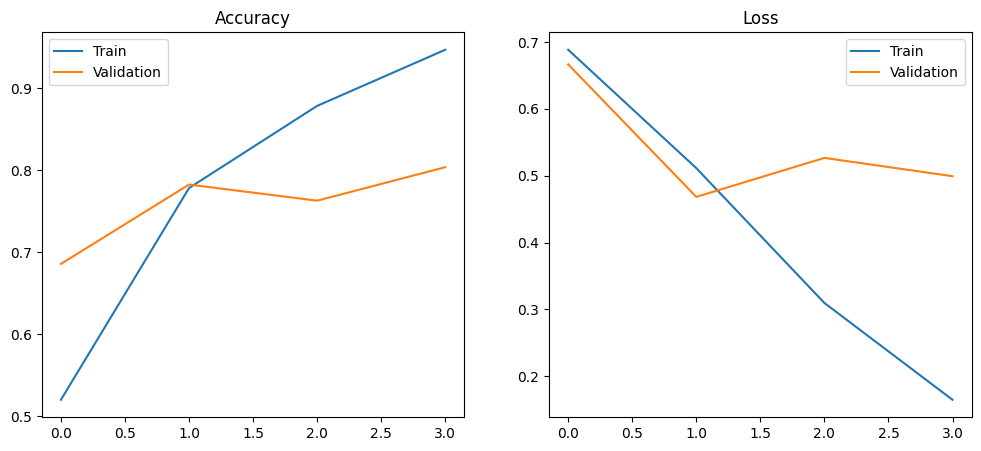

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
🗣 Text: I love this product!
Sentiment: Positive (0.93)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


🗣 Text: This is the worst experience ever.
Sentiment: Negative (0.12)
💾 Model saved as sentiment_rnn_model.h5


In [1]:
# ================================================
# 📘 SENTIMENT ANALYSIS USING RNN (LSTM)
# ================================================

!pip install tensorflow numpy pandas scikit-learn matplotlib --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Upload your CSV file
from google.colab import files
uploaded = files.upload()

# Load dataset
df = pd.read_csv('combined_sentiment_data.csv')
print("Dataset Shape:", df.shape)
df.head()

# Detect text & label columns automatically
possible_text_cols = ["text", "sentence", "review", "tweet", "content", "message"]
possible_label_cols = ["label", "sentiment", "target", "rating", "stars"]

text_col = next((c for c in df.columns if c.lower() in possible_text_cols), df.columns[0])
label_col = next((c for c in df.columns if c.lower() in possible_label_cols), df.columns[1])
df = df[[text_col, label_col]].dropna().rename(columns={text_col:"text", label_col:"label"})

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
print("Classes:", le.classes_)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label_encoded'], test_size=0.2, random_state=42, stratify=df['label_encoded'])

# Tokenize
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Build RNN (LSTM) Model
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
model.summary()

# Train
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=5,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.4f}")

# Plot accuracy & loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss'); plt.legend()
plt.show()

# Predict function
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(pad)[0][0]
    label = "Positive" if pred >= 0.5 else "Negative"
    print(f"🗣 Text: {text}\nSentiment: {label} ({pred:.2f})")

# Test predictions
predict_sentiment("I love this product!")
predict_sentiment("This is the worst experience ever.")

# Save model
model.save("sentiment_rnn_model.h5")
print("💾 Model saved as sentiment_rnn_model.h5")
